In [98]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [79]:
data = pd.read_csv("../data/nhgh.tsv", sep = "\t")
x = data.drop("gh", axis=1)
y = data["gh"].map(lambda x: 1 if x >= 6.5 else 0)

seed = 999

### Data Preprocessing

##### Data Imputation Analysis

There are lots of missing values in the dataset, and to cope with this, we simply use the training dataset to fill the values for both the training and test dataset. I do not utilize the test dataset for imputation at all in order to respect its secrecy, as the training process must not look at the test dataset. For the numeric columns, it is very straightforward, as we can simply take the mean of the training data's respective column. On the contrary for the factor columns (income), we need to do some extra steps. 

<Axes: xlabel='income'>

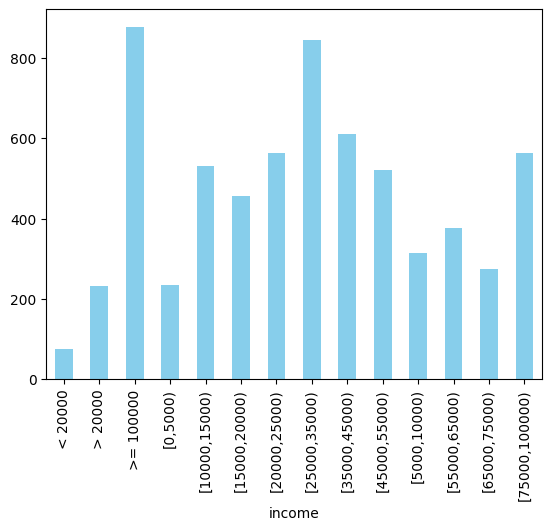

In [80]:
# Count the occurrences of each string
counts = data["income"].value_counts().sort_index()
counts.plot(kind="bar", color="skyblue")

From the bar graph above, we can clearly see that taking the mode of the column won"t suffice, as the distribution of the income is quite varied. Thus, setting 1 level for all the missing values will be not be an option. Usually if the incompleteness is severe, we can use a model to predict the column based on the other features. But in the case of income, as the number of missing value is less than 5%, we can just create a new level called "UNKOWN".

##### Preprocessing Pipeline

In [86]:
# Impute missing income using "UNKOWN" flag
x["income"].fillna("UNKOWN", inplace = True)
x["income"].fillna("UNKOWN", inplace = True)

# Convert factors into One Hot Encoding
onehot_x = pd.get_dummies(x, columns=["sex", "re", "income"], drop_first=True)

# Split data into train and test set
x_train, x_test, y_train, y_test = train_test_split(onehot_x, y, test_size=0.25, random_state=seed)

# Impute missing data using training data mean
x_train.fillna(x_train.mean(), inplace = True)
x_test.fillna(x_train.mean(), inplace = True)

### Logistic Regression Model

In [106]:
# Create a Logistic Regression model
lr = LogisticRegression(random_state=seed)

# Define hyperparameters to tune
lr_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "max_iter": [500, 1000]
}

# Use GridSearchCV for hyperparameter tuning
lr_grid_search = GridSearchCV(estimator=lr, param_grid=lr_grid, cv=5, scoring="accuracy")
lr_grid_search.fit(x_train, y_train)

# Get the best hyperparameters
lr_best_params = lr_grid_search.best_params_
print("Best Hyperparameters for Logistic Regression:", lr_best_params)

# Evaluate the model
lr_best_model = lr_grid_search.best_estimator_
lr_best_pred = lr_best_model.predict(x_test)
lr_acc = accuracy_score(y_test, lr_best_pred)
lr_conf = confusion_matrix(y_test, lr_best_pred)
lr_report = classification_report(y_test, lr_best_pred)

print(f"Accuracy: {lr_acc}\n")
print(f"Confusion Matrix:\n{lr_conf}\n")
print(f"Classification Report:\n{lr_report}")

c:\Users\zlyly\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\zlyly\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Best Hyperparameters for Logistic Regression: {'C': 100, 'max_iter': 1000, 'penalty': 'l2'}
Accuracy: 0.9034726309593879

Confusion Matrix:
[[1525   12]
 [ 152   10]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1537
           1       0.45      0.06      0.11       162

    accuracy                           0.90      1699
   macro avg       0.68      0.53      0.53      1699
weighted avg       0.87      0.90      0.87      1699



c:\Users\zlyly\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\zlyly\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\zlyly\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\zlyly\AppDa

### Decision Tree Model

Best Hyperparameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Accuracy: 0.9358446144791054

Confusion Matrix:
[[1485   52]
 [  57  105]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1537
           1       0.67      0.65      0.66       162

    accuracy                           0.94      1699
   macro avg       0.82      0.81      0.81      1699
weighted avg       0.93      0.94      0.94      1699



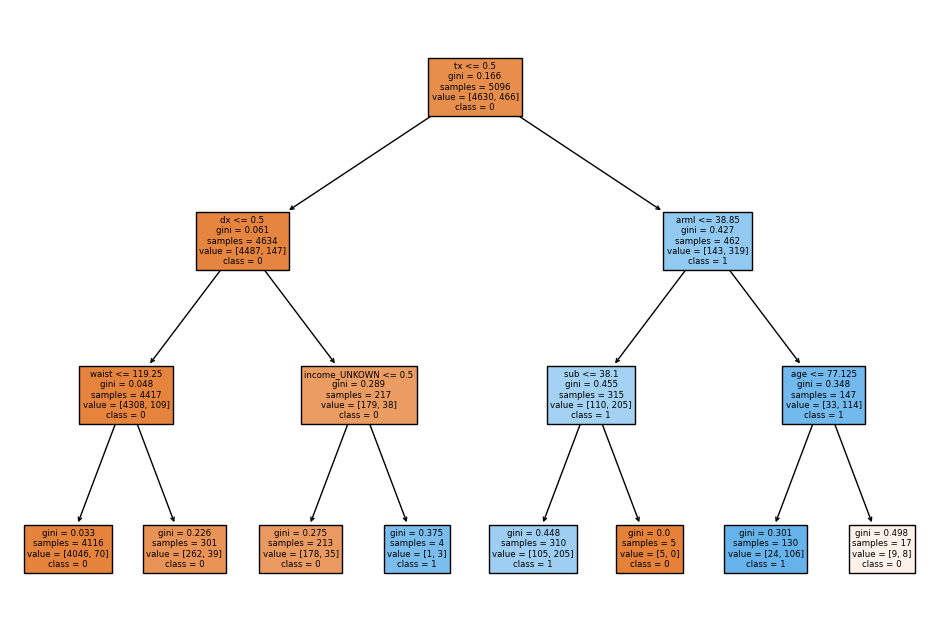

In [103]:
# Create a Decision Tree classifier
dt = DecisionTreeClassifier()

# Define hyperparameters to tune
dt_grid = {
    "max_depth": [3, 4, 5, 6],
    "min_samples_leaf": [2, 3, 4, 5],
    "min_samples_split": [2, 5, 8]
}

# Use GridSearchCV for hyperparameter tuning
dt_grid_search = GridSearchCV(estimator=dt, param_grid=dt_grid, cv=5, scoring="accuracy")
dt_grid_search.fit(x_train, y_train)

# Get the best hyperparameters
dt_best_params = dt_grid_search.best_params_
print("Best Hyperparameters:", dt_best_params)

# Evaluate the model
dt_best_model = dt_grid_search.best_estimator_
dt_best_pred = dt_best_model.predict(x_test)
dt_acc = accuracy_score(y_test, dt_best_pred)
dt_conf = confusion_matrix(y_test, dt_best_pred)
dt_report = classification_report(y_test, dt_best_pred)

print(f"Accuracy: {dt_acc}\n")
print(f"Confusion Matrix:\n{dt_conf}\n")
print(f"Classification Report:\n{dt_report}")

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt_best_model, feature_names=x_train.columns, class_names=["0", "1"], filled=True)
plt.show()

### Random Forest Model

In [104]:
# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=seed)

rf_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Use GridSearchCV for hyperparameter tuning
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_grid, cv=5, scoring="accuracy")
rf_grid_search.fit(x_train, y_train)

# Get the best hyperparameters
rf_best_params = rf_grid_search.best_params_
print("Best Hyperparameters for Random Forest:", rf_best_params)

# Evaluate the model
rf_best_model = rf_grid_search.best_estimator_
rf_best_pred = rf_best_model.predict(x_test)
rf_acc = accuracy_score(y_test, rf_best_pred)
rf_conf = confusion_matrix(y_test, rf_best_pred)
rf_report = classification_report(y_test, rf_best_pred)

print(f"Accuracy: {rf_acc}\n")
print(f"Confusion Matrix:\n{rf_conf}\n")
print(f"Classification Report:\n{rf_report}")

Best Hyperparameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.9334902884049441

Confusion Matrix:
[[1489   48]
 [  65   97]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1537
           1       0.67      0.60      0.63       162

    accuracy                           0.93      1699
   macro avg       0.81      0.78      0.80      1699
weighted avg       0.93      0.93      0.93      1699

